In [169]:
from automata.fa.dfa import DFA
from automata.fa.nfa import NFA 


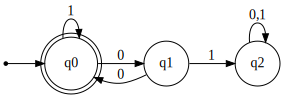

In [170]:
DFA(
    states={"q0", "q1", "q2"},
    input_symbols={"0", "1"},
    transitions={
        "q0": {"0": "q1", "1": "q0"},
        "q1": {"0": "q0", "1": "q2"},
        "q2": {"0": "q2", "1": "q2"},
    },
    initial_state="q0",
    final_states={"q0"},
).show_diagram()

In [171]:
A=DFA(
    states={"q0","q1","q2"},
    input_symbols={"0","1"},
    transitions={
        "q0":{"0":"q1","1":"q2"},
        "q1":{"0":"q0","1":"q2"},
        "q2":{"0":"q2","1":"q2"}
    },
    initial_state="q0",
    final_states={"q0"}
)

B=DFA(
    states={"q0","q1","q2"},
    input_symbols={"0","1"},
    transitions={
        "q0":{"1":"q1","0":"q2"},
        "q1":{"1":"q0","0":"q2"},
        "q2":{"1":"q2","0":"q2"}
    },
    initial_state="q0",
    final_states={"q0"}
)

In [172]:
state_id = -1

def get_next_state_id() -> int:
    """
    Returns a unique integer representing a state that exists.
    """
    global state_id
    state_id += 1
    return state_id


def find_and_replace(mapping: dict[str, str], s: set[str]) -> set[str]:
    """
    Replaces all existences of keys from `mapping` in `i` with values.
    Return the mutated set, leave the original alone.
    """
    return {mapping.get(val) for val in s}


def disambiguate_state_ids(s: DFA) -> tuple[DFA, dict[str, str]]:
    """
    Replace each state identifier with q{id} where id is a globally unique integer.
    """

    # derive a mapping from existing states ids in the dfa to new, unique state ids.
    mapping = {state: f"q{get_next_state_id()}" for state in s.states}

    new_transitions = dict()

    # "find and replace" for the dfa's transition functions
    for state, transition in s.transitions.items():
        new_transitions[mapping.get(state)] = {
            input_symbol: mapping.get(next_state)
            for input_symbol, next_state in transition.items()
        }

    # "find and replace" over states, initial state, and final states.
    return DFA(
        states=find_and_replace(mapping, s.states),
        input_symbols=s.input_symbols,
        transitions=new_transitions,
        initial_state=mapping.get(s.initial_state),
        final_states=find_and_replace(mapping, s.final_states),
    ), mapping


def convert_dfa_transitions_to_nfa_transitions(
    transitions: dict[str, dict[str, str]]
) -> dict[str, dict[str, set]]:
    new_transitions: dict[str, dict[str, set]] = dict()

    for state, transition in transitions.items():
        new_transition: dict[str, set] = dict()

        for symbol, next_state in transition.items():
            new_transition[symbol] = {next_state}

        new_transitions[state] = new_transition

    return new_transitions


def set_of_states_from_list(dfas: list[DFA]) -> set[str]:
    return set.union(*(set(dfa.states) for dfa in dfas))

def set_of_final_states_from_list(dfas: list[DFA]) -> set[str]:
    return set.union(*(set(dfa.final_states) for dfa in dfas))


def q2b(a: DFA, b: DFA) -> NFA:
    """
    The approach:
    1. Transition from all states in a -> b_copy (initial state)
    2. Transition from accept state of b_copy -> a_copy (exit point in a)
    """

    a, _ = disambiguate_state_ids(a)
    b, _ = disambiguate_state_ids(b)

    b_copies: list[DFA] = []
    a_copies: list[DFA] = []

    transitions: dict[str, dict[str, set]] = dict()
    transitions.update(convert_dfa_transitions_to_nfa_transitions(a.transitions))

    for a_state in a.states:
        b_copy, _ = disambiguate_state_ids(b.copy())
        transitions.update(convert_dfa_transitions_to_nfa_transitions(b_copy.transitions))

        # epsilon transition from state in a to a complete copy of b
        if "" not in transitions[a_state]:
           transitions[a_state][""] = set() 
        transitions[a_state][""].add(b_copy.initial_state)

        a_copy, mapping = disambiguate_state_ids(a.copy())
        exit_state = mapping[a_state]
        
        transitions.update(convert_dfa_transitions_to_nfa_transitions(a_copy.transitions))

        b_final_state = set(b_copy.final_states).pop()

        # epsilon transition from final state in b to complete copy of a
        if "" not in transitions[b_final_state]:
           transitions[b_final_state][""] = set() 
        transitions[b_final_state][""].add(exit_state)

        # store the copies to get the states later
        b_copies.append(b_copy)
        a_copies.append(a_copy)

    return NFA(
        states=set(a.states) | set_of_states_from_list(b_copies) | set_of_states_from_list(a_copies),
        input_symbols=a.input_symbols | b.input_symbols,
        transitions=transitions,
        initial_state=a.initial_state,
        final_states=set_of_final_states_from_list(a_copies)
    )


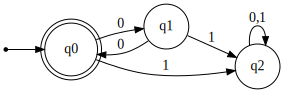

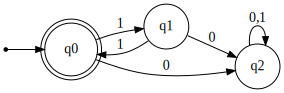

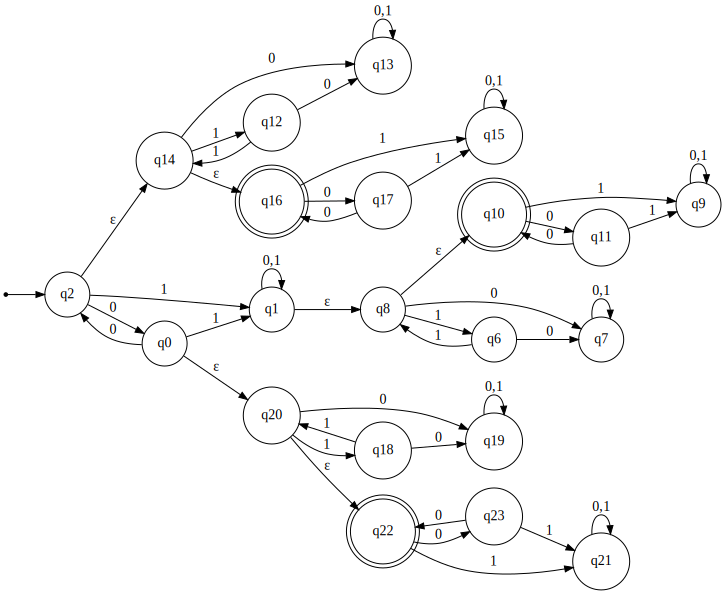

In [173]:
display(A)
display(B)
display(q2b(A, B))